## Imports for Zephyr-7B

In [ ]:
# Install transformers from source - only needed for versions <= v4.34
%pip install git+https://github.com/huggingface/transformers.git
%pip install accelerate

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-gzg027nj
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-gzg027nj
  Resolved https://github.com/huggingface/transformers.git to commit 453079c7f843e7eb920a47fcdaa431413ac0fe72
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Imports for PaddleOCR

In [ ]:
#Only needed for Google Collab, Ignore if running in local machine
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
!git clone https://github.com/PaddlePaddle/PaddleOCR.git

fatal: destination path 'PaddleOCR' already exists and is not an empty directory.


In [ ]:
!python3 -m pip install paddlepaddle-gpu

In [ ]:
!pip install "paddleocr>=2.0.1"

## OCR using PaddleOCR

In [ ]:
from paddleocr import PaddleOCR,draw_ocr
# Paddleocr supports Chinese, English, French, German, Korean and Japanese.
# You can set the parameter `lang` as `ch`, `en`, `fr`, `german`, `korean`, `japan`
# to switch the language model in order.
ocr = PaddleOCR(use_angle_cls=True, lang='en',use_space_char=True,show_log=False,enable_mkldnn=True)

In [ ]:
from google.colab.patches import cv2_imshow
import cv2

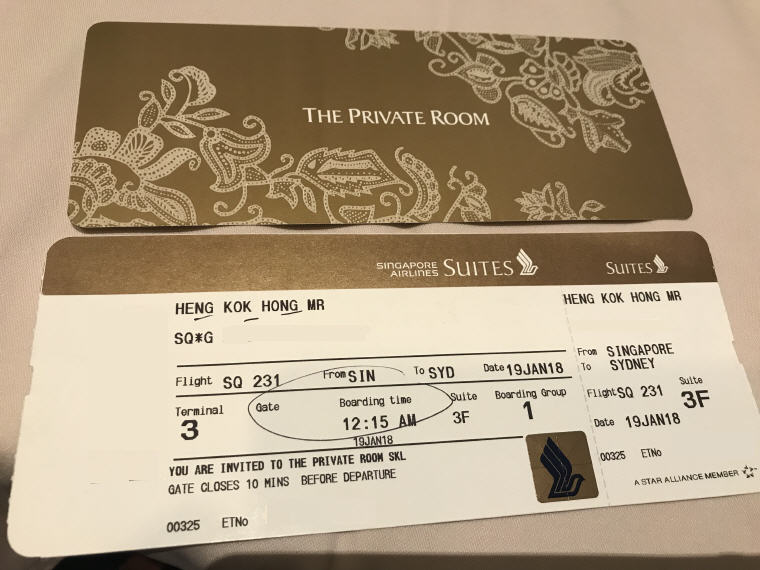

In [ ]:
img_path = '/content/singapore.jpg'

img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
cv2_imshow(img)

In [ ]:
result = ocr.ocr(img_path, cls=True)

In [ ]:
ocr_string = ""
# Extract the text from the OCR result and concatenate it to ocr_string
for i in range(len(result[0])):
    ocr_string = ocr_string + result[0][i][1][0] + " "

In [ ]:
ocr_string

'THE PRIVATE ROOM SIGAPORE SUITES SUITES HENG KOK HONGMR HENG KOK HONG MR SQ*G Fron SINGAPORE TOSYD Date19JAN18 To SYDNEY Flight SQ 231 FronSIN Sulte sutte Boarding Group FlightSQ231 Boarding time 3F Terminal Gate 3F 3 12:15AM Date 19JAN18 19JAN18 00325 ETNo YOU ARE INVITED TO THE PRIVATE ROOM SKL GATE CLOSES 10 MINS BEFORE DEPARTURE A STAR ALLIANCEMEMBER 00325 ETNO '

## OCR Output Parsing using LLM

In [ ]:
import torch
from transformers import pipeline

In [ ]:
pipe = pipeline("text-generation", model="HuggingFaceH4/zephyr-7b-alpha", torch_dtype=torch.bfloat16, device_map="auto")

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
ocr_string="THE PRIVATE ROOM SINGAPORE SUITES SUITES HENG KOK HONGMR HENG KOK HONG MR SQ*G Fron SINGAPORE TOSYD Date19JAN18 To SYDNEY Flight SQ 231 FronSIN Sulte sutte Boarding Group FlightSQ231 Boarding time 3F Terminal Gate 3F 3 12:15AM Date 19JAN18 19JAN18 00325 ETNo YOU ARE INVITED TO THE PRIVATE ROOM SKL GATE CLOSES 10 MINS BEFORE DEPARTURE A STAR ALLIANCEMEMBER 00325 ETNO"

In [ ]:
# Each message can have 1 of 3 roles: "system" (to provide initial instructions), "user", or "assistant". For inference, make sure "user" is the role in the final message.
messages = [
    {
        "role": "system",
        "content": "You are a JSON converter which receives raw boarding pass OCR information as a string and returns a structured JSON output by organising the information in the string.",
    },
    {"role": "user", "content": f"Extract the name of the passenger, name of the airline, Flight number, City of Departure, City of Arrival, Date of Departure from this OCR data: {ocr_string}"},
]
# We use the tokenizer's chat template to format each message - see https://huggingface.co/docs/transformers/main/en/chat_templating
prompt = pipe.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
print(prompt)

<|system|>
You are a JSON converter which receives raw boarding pass OCR information as a string and returns a structured JSON output by organising the information in the string.</s>
<|user|>
Extract the name of the passenger, name of the airline, Flight number, City of Departure, City of Arrival, Date of Departure from this OCR data: THE PRIVATE ROOM SINGAPORE SUITES SUITES HENG KOK HONGMR HENG KOK HONG MR SQ*G Fron SINGAPORE TOSYD Date19JAN18 To SYDNEY Flight SQ 231 FronSIN Sulte sutte Boarding Group FlightSQ231 Boarding time 3F Terminal Gate 3F 3 12:15AM Date 19JAN18 19JAN18 00325 ETNo YOU ARE INVITED TO THE PRIVATE ROOM SKL GATE CLOSES 10 MINS BEFORE DEPARTURE A STAR ALLIANCEMEMBER 00325 ETNO</s>
<|assistant|>



In [ ]:
outputs = pipe(prompt, max_new_tokens=1000, do_sample=True, temperature=0.7, top_k=50, top_p=0.95)
print(outputs[0]["generated_text"])

<|system|>
You are a JSON converter which receives raw boarding pass OCR information as a string and returns a structured JSON output by organising the information in the string.</s>
<|user|>
Extract the name of the passenger, name of the airline, Flight number, City of Departure, City of Arrival, Date of Departure from this OCR data: THE PRIVATE ROOM SINGAPORE SUITES SUITES HENG KOK HONGMR HENG KOK HONG MR SQ*G Fron SINGAPORE TOSYD Date19JAN18 To SYDNEY Flight SQ 231 FronSIN Sulte sutte Boarding Group FlightSQ231 Boarding time 3F Terminal Gate 3F 3 12:15AM Date 19JAN18 19JAN18 00325 ETNo YOU ARE INVITED TO THE PRIVATE ROOM SKL GATE CLOSES 10 MINS BEFORE DEPARTURE A STAR ALLIANCEMEMBER 00325 ETNO</s>
<|assistant|>
Here's the JSON output:

```json
{
  "Passenger": {
    "Name": "HENG KOK HONG MR"
  },
  "Airlines": {
    "Name": "SQ"
  },
  "Flight": {
    "Number": "SQ 231",
    "Departure": {
      "City": "SINGAPORE",
      "Date": "19JAN18",
      "Time": "12:15AM"
    },
    "Arriv

## End-to-End Solution (May not run in collab due to collab memory being limited)

In [ ]:
def Image_to_JSON(image_path):
    # Perform OCR on the image and extract the text content
    result = ocr.ocr(image_path, cls=True)

    ocr_string = ""  # Stores the OCR content extracted from the image in a string which can be fed into ChatGPT

    # Extract the text from the OCR result and concatenate it to ocr_string
    for i in range(len(result[0])):
        ocr_string = ocr_string + result[0][i][1][0] + " "

    messages = [
    {
        "role": "system",
        "content": "You are a JSON converter which receives raw boarding pass OCR information as a string and returns a structured JSON output by organising the information in the string.",
    },
    {"role": "user", "content": f"Extract the name of the passenger, name of the airline, Flight number, City of Departure, City of Arrival, Date of Departure from this OCR data: {ocr_string}"},
    ]
    # We use the tokenizer's chat template to format each message - see https://huggingface.co/docs/transformers/main/en/chat_templating
    prompt = pipe.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    outputs = pipe(prompt, max_new_tokens=1000, do_sample=True, temperature=0.7, top_k=50, top_p=0.95)
    print(outputs[0]["generated_text"])

In [ ]:
Image_to_JSON('/content/singapore.jpg')